# Outline
1. EDA
2. Deal with missing value
3. Feature engineering
4. Preprocessing(normalization, skewness, imbalance)
5. Model training
6. Evaluation
7. Prediction

## Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helper functions

In [86]:
# show the missing value percentage for features
def missing_value_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / len(df)).sort_values(ascending=False)*100
    percentage_str = percentage.map('{:.2f}%'.format)
    missing_data = pd.concat([total, percentage_str], axis = 1, keys=['Total', 'Percentage'])
    missing_data = missing_data[total > 0]

    return missing_data

In [151]:
def random_select(df, target, features):
    selection = df[target].sample(n=1).iloc[0]
    df_selected = df[df[target] == selection][[target] + features]
    return df_selected

## Load data

### payment_data.csv:
payment_data.csv: customer’s card payment history.
id: customer id
OVD_t1: number of times overdue type 1
OVD_t2: number of times overdue type 2
OVD_t3: number of times overdue type 3
OVD_sum: total overdue days
pay_normal: number of times normal payment
prod_code: credit product code
prod_limit: credit limit of product
update_date: account update date
new_balance: current balance of product
highest_balance: highest balance in history
report_date: date of recent payment

### customer_data.csv:
customer’s demographic data and category attributes which have been encoded.
Category features are fea_1, fea_3, fea_5, fea_6, fea_7, fea_9.
label is 1, the customer is in high credit risk
label is 0, the customer is in low credit risk

In [140]:
customer_data = pd.read_csv("customer_data.csv")
payment_data = pd.read_csv("payment_data.csv")

In [143]:
payment_data['report_date'] = pd.to_datetime(payment_data['report_date'], format='%d/%m/%Y')
payment_data['update_date'] = pd.to_datetime(payment_data['update_date'], format='%d/%m/%Y')

In [145]:
payment_data.dtypes

id                          int64
OVD_t1                      int64
OVD_t2                      int64
OVD_t3                      int64
OVD_sum                     int64
pay_normal                  int64
prod_code                   int64
prod_limit                float64
update_date        datetime64[ns]
new_balance               float64
highest_balance           float64
report_date        datetime64[ns]
dtype: object

# EDA

In [27]:
customer_data.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [5]:
customer_data.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [28]:
payment_data.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [6]:
payment_data.describe()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,34.000000,34.000000,35.000000,31500.000000,36.000000,27.000000,660000.000000,1.632120e+08,1.800005e+08


In [81]:
print("num of id in customer_data:",customer_data.id.count())
print("unique num of id in customer_data:",customer_data.id.nunique())
print("num of id in payment_data:",payment_data.id.count())
print("unique num of id in payment_data:",payment_data.id.nunique())

num of id in customer_data: 1125
unique num of id in customer_data: 1125
num of id in payment_data: 8250
unique num of id in payment_data: 1125


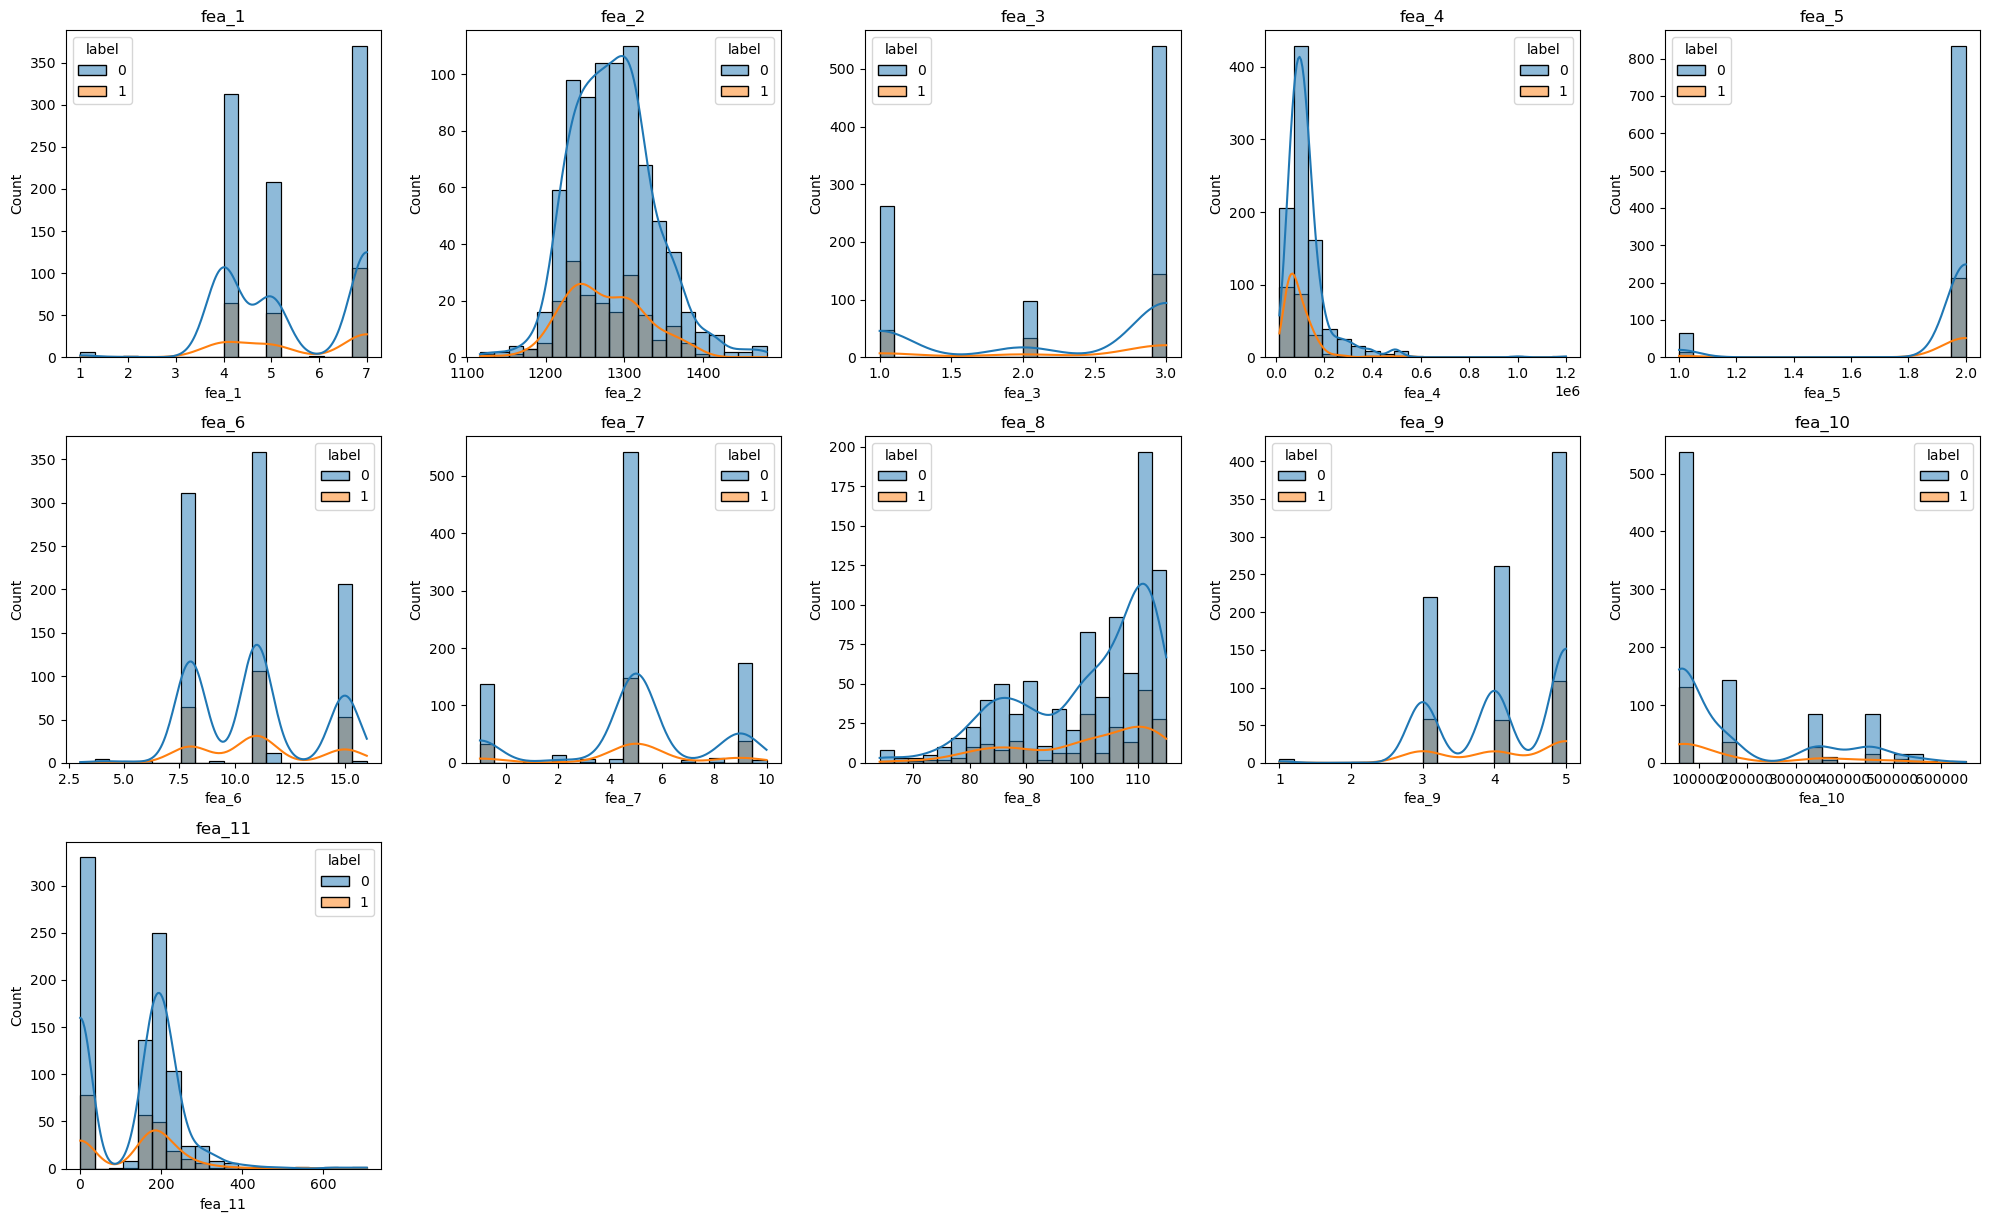

In [84]:
customer_features = customer_data.columns[2:]

fig = plt.figure(figsize=(20,20))

for idx, val in enumerate(customer_features):
    ax = fig.add_subplot(5, 5, idx+1)
    sns.histplot(data=customer_data, x=val, axes=ax, bins=20 ,hue='label', kde=True)
    ax.set_title(val)

plt.tight_layout()
plt.show()


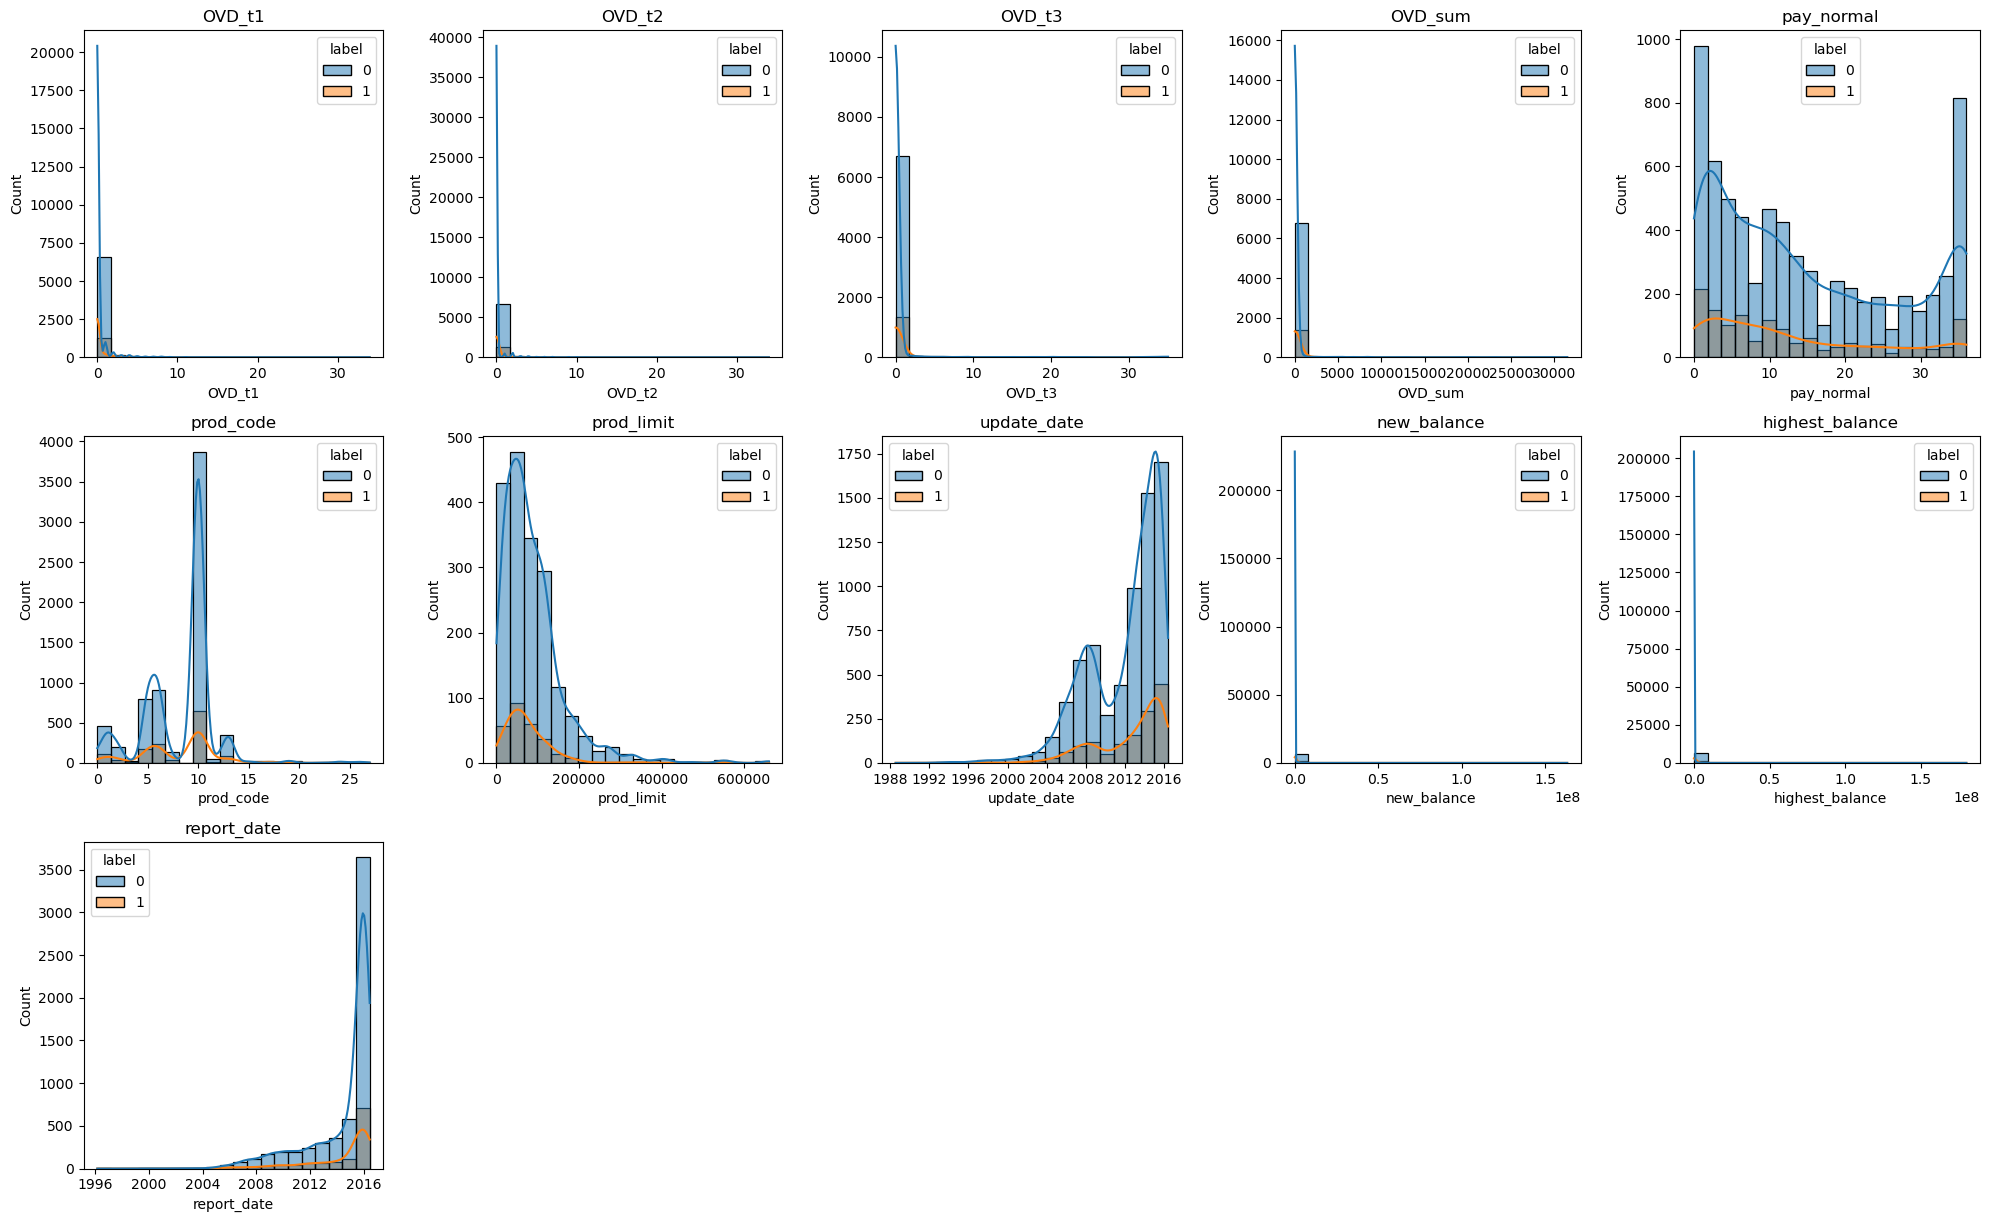

In [228]:
payment_features = payment_data.columns[1:]
payment_data_label = pd.merge(payment_data,customer_data[["id","label"]], how="left", on="id")

fig = plt.figure(figsize=(20,20))

for idx, val in enumerate(payment_features):
    ax = fig.add_subplot(5, 5, idx+1)
    sns.histplot(data=payment_data_label, x=val, axes=ax, bins=20 ,hue='label', kde=True)
    ax.set_title(val)

plt.tight_layout()
plt.show()


In [195]:
full_data = pd.merge(payment_data,customer_data, how="left", on="id")
target = customer_data["label"]
feature_data = full_data[full_data.columns[1:]]
features = feature_data.columns

<Axes: >

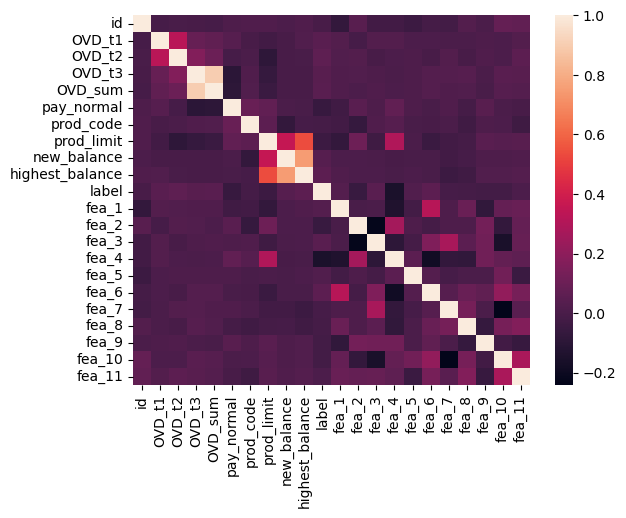

In [172]:
numerical_features = [col for col in full_data.columns if full_data[col].dtype in ["float64","int64"]]
corr_matrix = full_data[numerical_features].corr()
sns.heatmap(corr_matrix)

# Dealing with missing values

In [149]:
missing_value_percentage(full_data)

,Total,Percentage
prod_limit,6118,74.16%
report_date,1114,13.50%
fea_2,1028,12.46%
highest_balance,409,4.96%
update_date,26,0.32%


In [243]:
random_select(full_data, "id", ["pay_normal","prod_limit","prod_code","report_date",'new_balance',"highest_balance",'label']).sort_values("report_date", ascending=False)

,id,pay_normal,prod_limit,prod_code,report_date,new_balance,highest_balance,label
2070,58985870,12,23100.0,10,2015-12-18,25315.2,26423.0,0
1881,58985870,7,59400.0,10,2015-12-12,15612.0,24869.0,0
1004,58985870,5,NaN,10,2015-12-11,-356.4,15731.0,0
1166,58985870,5,NaN,5,2015-10-23,171872.4,150500.0,0
5258,58985870,12,NaN,12,2015-05-15,22666.8,19250.0,0
6317,58985870,2,NaN,10,2014-01-01,0.0,54688.0,0
4966,58985870,5,NaN,7,NaT,0.0,25500.0,0
